# Временные ряды

## Описание проекта:
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.
## Описание данных:
|признак|описание|
|---|---|
|num_orders|число заказов|

## Оптимизируемая метрика качества:


_rmse_ = $\sqrt{\frac{\sum\limits_{i=1}^T (y'_i-y_i)^2}{T}}$



## Этапы работы:

0. Импорт библиотек, функция метрики, объявление констант

1. Загрузка данных и ресемплирование по одному часу

2. Анализ(декомпозиция, выявление выбросов)

3. Обучение моделей, подбор гиперпараметров, предсказания для тестовой выборки

    3.1. Извлекаем признаки (месяц, день, день недели, час, день года, неделя года, четверть года, лаги)    
    3.2. Делим данные на тренировочную, отложенную, тестовую части    
    3.3. Дамми-модель    
    3.4. Создаем пайплайны    
    3.5. Результаты на валидации и на отложенной выборках    
    3.6. Предсказания для тестовой выборки 
    
## Финальные выводы:

* в ряде наблюдается тренд
* остатки ряда распределены нормально
* присутствуют выбросы (с августа 2018)
* Lightgbm показал наилучший результат с исходными признаками, отобрав 12 наилучших из 55 исходных
* дольше всех обучался бустинг, далее - ближайшие соседи, дерево решений и линейная регрессия обучались примерно одинаково быстро

|валидационная выборка|отложенная выборка|тестовая выборка|
|---|---|---|
|23|32|44|

* ошибка прогноза количества заказов такси на следующий час с помощью бустинга составляет не больше 45 машин

### 0. Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
import os, re, sys, gc, pickle, time
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid,\
                                    KFold, TimeSeriesSplit,\
                                    train_test_split,\
                                    cross_validate, cross_val_score
from sklearn.metrics import make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, OneHotEncoder 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from scipy.sparse import hstack, vstack, csc_matrix
from sklearn.model_selection import RandomizedSearchCV

In [2]:
try:
    import category_encoders as ce
except:
    !pip install category_encoders
    import category_encoders as ce

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 80 kB 810 kB/s eta 0:00:011


### 0. Метрика качества, константы

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

SEED = 13
TSCV = TimeSeriesSplit(5)
TEST_SIZE = .1
ALPHA = .05

### 1. Загрузка данных и ресемплирование по одному часу

In [4]:
try:
    ts_ser = pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col = [0])['num_orders'].resample('1H').sum()
except:
    ts_ser = pd.read_csv('datasets/taxi.csv', parse_dates = [0], index_col = [0])['num_orders'].resample('1H').sum()    

#### Выводы:
* загрузка с параметрами parse_dates(парсинг даты), index_col(колонка-индекс)
* ресемплирование с помощью метода resample

### 2. Анализ(декомпозиция, выявление выбросов)

In [5]:
x, y = np.arange(len(ts_ser)), ts_ser.values
q25, q75 = np.percentile(y, [25, 75])
iqr = q75-q25
outliers_mask = (y<(q25-3*iqr)) | (y>(q75+3*iqr))
poly1=np.poly1d(np.polyfit(x[~outliers_mask], y[~outliers_mask], 1))
ts_decomp = seasonal_decompose(ts_ser.resample('1D').sum())
ts_trend= ts_decomp.trend.dropna()
ts_seasonal=ts_decomp.seasonal.dropna()
ts_resid= ts_decomp.resid.dropna()

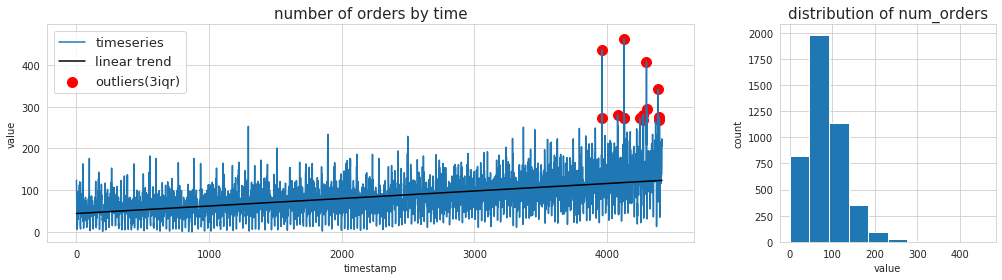

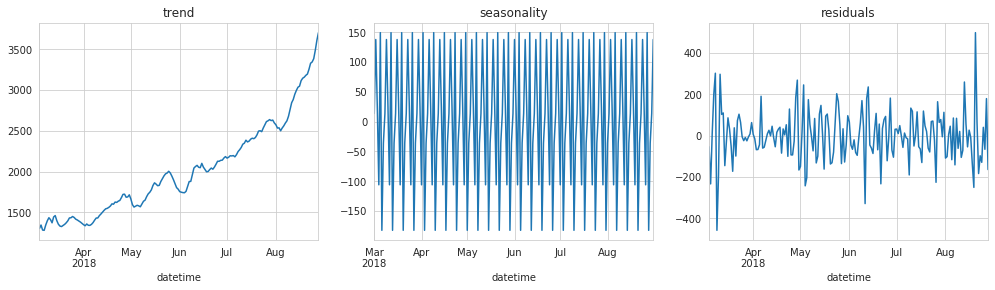

In [6]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (17, 4), gridspec_kw={'width_ratios': [3, 1]})
ax0.plot(x,y)
ax0.plot(sorted(x), poly1(sorted(x)), color = 'black')
ax0.scatter(x[outliers_mask], y[outliers_mask], color ='red', s = 100)
ax0.set_xlabel('timestamp')
ax0.set_ylabel('value')
ax0.set_title('number of orders by time', fontsize = 15)
ax0.legend(['timeseries', 'linear trend', 'outliers(3iqr)'], fontsize = 13)

ts_ser.hist(ax = ax1)
ax1.set_title('distribution of num_orders', fontsize= 15)
ax1.set_xlabel('value')
ax1.set_ylabel('count')

fig2, (ax2, ax3, ax4) = plt.subplots(1, 3, figsize = (17, 4))
ts_trend.plot(ax = ax2)
ax2.set_title('trend')

ts_seasonal.plot(ax = ax3)
ax3.set_title('seasonality')

ts_resid.plot(ax = ax4)
ax4.set_title('residuals')
plt.show()

#### Выводы:
* наблюдается тренд
* судя по графикам, остатки распределены нормально
* присутствуют выбросы (с августа 2018)

### 3. Обучение моделей, подбор гиперпараметров, предсказания для тестовой выборки

In [7]:
def add_time_features(ts_tr, n_steps, window_size):
    '''Извлекает признаки из ряда'''
    # список с признаками
    features = []    
    
    # месяц, день, день недели, час, день года, неделя года, четверть года
    features.append(ts_tr.index.month)
    features.append(ts_tr.index.day)
    features.append(ts_tr.index.dayofweek)
    features.append(ts_tr.index.hour)
    features.append(ts_tr.index.dayofyear)
    features.append(ts_tr.index.weekofyear)
    features.append(ts_tr.index.quarter)
    
    feature_names = ['month', 'day', 'dayofweek', 'hour', 'dayofyear', 'weekofyear', 'quarter']

    # лаги
    for n in range(1, n_steps+1):
        shifted = ts_tr.shift(n)
        features.append(shifted)
        features.append(shifted.rolling(window_size).mean())        
        feature_names.append(f'lag_{n}')
        feature_names.append(f'lag_{n}_rolling_{window_size}_mean')     
    
    df_feat = pd.DataFrame(np.column_stack(features), columns = feature_names, index = ts_tr.index).dropna()     
    df_target = ts_tr.loc[df_feat.index]
    return (df_feat, df_target) 

#### 3.1. Извлекаем признаки (месяц, день, день недели, час, день года, неделя года, четверть года, лаги)

In [8]:
FEATURES, TARGETS = add_time_features(ts_ser, n_steps=24, window_size = 24)

In [9]:
print('размерность признаков = {}'.format(FEATURES.shape))

размерность признаков = (4369, 55)


#### 3.2. Делим данные на тренировочную, отложенную, тестовую части

In [10]:
x_tr, x_te, y_tr, y_te = train_test_split(FEATURES, TARGETS, test_size = TEST_SIZE, shuffle = False)
idx_split = int(len(x_tr)*.9)

#### 3.3. Дамми-модель

In [11]:
cvAB = pd.DataFrame()
durAB = pd.DataFrame()

dummy_reg = DummyRegressor('mean')
cvAB.loc['baseline', 'cv'] = np.abs(cross_val_score(dummy_reg, x_tr.iloc[:idx_split], y_tr.iloc[:idx_split],\
                                 cv = TSCV, scoring = rmse_scorer).mean())
durAB.loc['baseline', 'cv'] = np.nan

dummy_reg.fit(x_tr.iloc[:idx_split], y_tr.iloc[:idx_split])
cvAB.loc['baseline', 'hold'] = rmse(y_tr.iloc[idx_split:], dummy_reg.predict(x_tr.iloc[idx_split:]))
durAB.loc['baseline', 'hold'] = np.nan

dummy_reg.fit(x_tr, y_tr)
cvAB.loc['baseline', 'test'] = rmse(y_te, dummy_reg.predict(x_te))
durAB.loc['baseline', 'test'] = np.nan

In [12]:
cvAB

,cv,hold,test
baseline,37.798434,57.774741,84.740259


#### 3.4. Создаем пайплайны
* линейная регрессия (категории преобразуем с помощью one hot)
* дерево решений
* случайный лес
* бустинг
* кнн

In [13]:
class SklearnHelperColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.columns]

In [14]:
class SklearnHelperTargetEncoder(TransformerMixin, BaseEstimator):
    
    def __init__(self,  to_encode, n_iterations, nfolds_range, seed, idx_split):
        self.n_iterations = n_iterations
        self.nfolds_range = nfolds_range
        self.seed = seed
        self.idx_split = idx_split
        self.to_encode = to_encode
    def fit(self, X, y=None):        
    
        # пустые даатфреймы
        df_enc_tr = pd.DataFrame(index = X.index[:self.idx_split], columns = self.to_encode).fillna(0.0)
        df_enc_hold = pd.DataFrame(index = X.index[self.idx_split:], columns = self.to_encode).fillna(0.0)
        
        D_enc = {}

        # 1) кодируем с помощью двух стратегий
        # 2) повторяя кодирование 20 раз, используя разные разбиения на фолды
        # 3) усредняем кодирования
        self.encoders = []
        n_iterations = self.n_iterations
        for _ in tqdm_notebook(range(n_iterations)):
            np.random.seed(self.seed+_)
            encoder1 = ce.CatBoostEncoder(cols = self.to_encode,\
                                              sigma = y.mean()*np.random.choice(np.linspace(.001, .05, 1000)),\
                                              a = np.random.choice(range(1, 5)))                                          
            encoder2 = ce.TargetEncoder(cols = self.to_encode, min_samples_leaf = np.random.choice(np.arange(2, 21)))
            nfolds = np.random.choice(self.nfolds_range)
            for tr_idx, val_idx in KFold(nfolds, random_state = self.seed+_).split(y.iloc[:self.idx_split]):
                encoder1.fit(X[self.to_encode].iloc[tr_idx], y.iloc[tr_idx])
                encoder2.fit(X[self.to_encode].iloc[tr_idx], y.iloc[tr_idx])
                self.encoders.append(encoder1)
                self.encoders.append(encoder2)
        return self
    def transform(self,X):
        L=[]
        for encoder in self.encoders:
            L.append(encoder.transform(X[self.to_encode]))
        return sum(L)/len(L) 



In [15]:
class SklearnHelperFeatureSelector(BaseEstimator, TransformerMixin):
    '''
    Отбирает признаки
    
    параметры:
        1) model - модель, с помощью которой производится отбор
        2) metric - оптимизируемая метрика качества
        3) cv - валидация
        4) larger_is_better - критерий оптимизации
        5) early_stopping - ранняя остановка
    возвращает: датасет с отобранными признаками
    
    '''    
    def __init__(self, model, metric, cv, early_stopping):
        self.model = model
        self.metric = metric
        self.cv = cv
        self.early_stopping = early_stopping
        
    def fit(self, X, y):        
        import scipy
        if not(isinstance(X,scipy.sparse.csc_matrix)):
            _X = csc_matrix(X)
        else:
            _X = X.copy()
        nfeatures = _X.shape[1]    
        scores_L = []
        for i in tqdm_notebook(range(nfeatures)):
            mean_score = cross_validate(self.model, _X[:, i], y, scoring= self.metric, cv = self.cv)['test_score'].mean()
            scores_L.append(mean_score)
            
        order = np.argsort(scores_L)[::-1]            
        best_score = -np.inf
        
        best_features, feat_to_drop = [], []
        counter = 0
        for i in tqdm_notebook(order):
            current_features = best_features+[i]
            current_score = cross_validate(self.model,\
                                           _X[:, current_features], y,\
                                           scoring= self.metric,\
                                           cv = self.cv)['test_score'].mean()
            if current_score>best_score:
                best_score = current_score
                best_features = current_features                    
            else:               
                feat_to_drop.append(i)
                counter+=1
                if counter == self.early_stopping:
                    break
                    
        feat_to_drop_before = feat_to_drop
        feat_to_drop_after = []
        counter = 0
        while True:
            for i in tqdm_notebook(feat_to_drop_before):
                current_features = best_features+[i]
                current_score = cross_validate(self.model,\
                                               _X[:, current_features], y,\
                                               scoring= self.metric,\
                                               cv = self.cv)['test_score'].mean()
                
                if current_score>best_score:
                    best_score = current_score
                    best_features = current_features   
                    counter = 0
                else:
                    counter+=1
                    feat_to_drop_after.append(i)
                    if counter == self.early_stopping:
                        break
                        
            if len(feat_to_drop_after) == len(feat_to_drop_before):
                break 
            else:
                feat_to_drop_before = feat_to_drop_after
                feat_to_drop_after = []                
                
        self.best_features = best_features
        self.best_score = best_score
        
        return self
        
    def transform(self, X):
        import scipy
        if not(isinstance(X,scipy.sparse.csc_matrix)):
            _X = csc_matrix(X)
        else:
            _X = X.copy()
                
        return _X[:, self.best_features]

In [16]:
columns_to_encode = ['month', 'day', 'dayofweek', 'hour', 'dayofyear', 'weekofyear', 'quarter']
columns_other = x_tr.drop(columns_to_encode, 1).columns.tolist()

In [17]:
pipe_ohe = Pipeline([('select columns', SklearnHelperColumnSelector(columns_to_encode)),\
                     ('one hot encoding', OneHotEncoder(handle_unknown='ignore'))])
pipe_others_scale = Pipeline([('select columns', SklearnHelperColumnSelector(columns_other)),\
                              ('scaler', MinMaxScaler())])
pipe_target_enc = Pipeline([('select columns', SklearnHelperColumnSelector(columns_to_encode)),\
                            ('target encoding', Pipeline(steps= [('target_enc',\
                                                             SklearnHelperTargetEncoder(to_encode = columns_to_encode,\
                                                                                        n_iterations= 10,\
                                                                                        nfolds_range = np.arange(5,21),\
                                                                                        seed = SEED,\
                                                                                        idx_split = idx_split))]))])
pipe_raw = Pipeline([('select columns', SklearnHelperColumnSelector(columns_to_encode+columns_other)),\
                     ('scaler', MinMaxScaler())])


<div class="alert alert-info">
    
удалил случайный лес(долго обучается)
    
весь процесс занял 7 минут

</div>

In [18]:
# ('rf', RandomForestRegressor(random_state = SEED), {'max_depth' : list(range(2, 11))+[None],\
#                                                     'min_samples_split':[0, 2, 10]}),\
L_model_grid = (('lr', LinearRegression(), None),\
                ('knn', KNeighborsRegressor(), {'n_neighbors': list(range(1, 11))}),\
                ('dt', DecisionTreeRegressor(random_state = SEED), {'max_depth' : list(range(2, 11))+[None],\
                                                                    'min_samples_split':[0, 2, 10]}),\
                ('lgb', LGBMRegressor(random_state = SEED), {'max_depth': list(range(2, 11)),\
                                                             'num_leaves':[2, 4, 8, 16, 24, 32, 48, 64],\
                                                             'min_child_samples':[0, 2, 10],\
                                                             'subsample' : [.5, .7, 1], 'colsample_bytree':[.5, .7, 1]}))

In [ ]:
D_ppl_res ={}
L_results = []

for model_name, model, grid in tqdm_notebook(L_model_grid, total = len(L_model_grid)):     
    if model_name == 'lr':
        names = ('ohe', 'target', 'raw')
        pipelines = (Pipeline([('preprocessing', FeatureUnion([('ohe',pipe_ohe), ('scale', pipe_others_scale)])),\
                               ('feature selection', SklearnHelperFeatureSelector(model = model,\
                                                                               metric = rmse_scorer,\
                                                                               cv =TSCV,\
                                                                               early_stopping=None))]),\
                     Pipeline([('preprocessing', FeatureUnion([('target_enc',pipe_target_enc), ('scale', pipe_others_scale)])),\
                               ('feature selection', SklearnHelperFeatureSelector(model = model,\
                                                                                  metric = rmse_scorer,\
                                                                                  cv =TSCV,\
                                                                                  early_stopping=None))]),\
                     Pipeline([('preprocessing', FeatureUnion([('scale', pipe_raw)])),\
                               ('feature selection', SklearnHelperFeatureSelector(model = model,\
                                                                                metric = rmse_scorer,\
                                                                                cv =TSCV,\
                                                                                early_stopping=None))]))    
    else:
        names = ('target', 'raw')
        pipelines = (Pipeline([('preprocessing', FeatureUnion([('target_enc',pipe_target_enc), ('scale', pipe_others_scale)])),\
                               ('feature selection', SklearnHelperFeatureSelector(model = model,\
                                                                                  metric = rmse_scorer,\
                                                                                  cv =TSCV,\
                                                                                  early_stopping=None))]),\
                     Pipeline([('preprocessing', FeatureUnion([('scale', pipe_raw)])),\
                               ('feature selection', SklearnHelperFeatureSelector(model = model,\
                                                                                metric = rmse_scorer,\
                                                                                cv =TSCV,\
                                                                                early_stopping=None))]))  
    for ppl_name, ppl in tqdm_notebook(zip(names, pipelines), total = len(pipelines)):
        key = '.'.join([model_name, ppl_name])
        ppl.fit(x_tr.iloc[:idx_split], y_tr.iloc[:idx_split])
        x_sel_tr, x_sel_te = ppl.transform(x_tr), ppl.transform(x_te)
        D_ppl_res[key] = {'tr':x_sel_tr, 'te':x_sel_te}   
        
        if model_name != 'lr':
            start = time.time()
            rs = RandomizedSearchCV(estimator = model,\
                                    param_distributions = grid,\
                                    n_iter = 5,\
                                    random_state=SEED,\
                                    scoring = rmse_scorer,\
                                    cv = TSCV)
            if model_name == 'lgb':
                rs.fit(x_sel_tr[:idx_split], y_tr.iloc[:idx_split])
                curr_model = model.set_params(**rs.best_params_)
                rs2 = GridSearchCV(estimator =curr_model,\
                                   param_grid = {'learning_rate': np.linspace(.01, .1, 10)},\
                                   scoring = rmse_scorer, cv = TSCV)
                rs2.fit(x_sel_tr[:idx_split], y_tr.iloc[:idx_split])
                best_est = rs2.best_estimator_
                best_cv_score = rs2.best_score_           

            else:            
                rs.fit(x_sel_tr[:idx_split], y_tr.iloc[:idx_split])
                best_est = rs.best_estimator_
                best_cv_score = rs.best_score_
            end = time.time()
            holdout_score = rmse(y_tr.iloc[idx_split:], best_est.predict(x_sel_tr[idx_split:]))
            
            L_results.append((model_name, ppl_name, np.abs(best_cv_score), holdout_score, round(end-start), str(best_est.get_params())))            
        else:
            start = time.time()
            best_cv_score = cross_val_score(model, x_sel_tr[:idx_split], y_tr.iloc[:idx_split],\
                                            scoring = rmse_scorer, cv = TSCV).mean()
            end = time.time()
            
            model.fit(x_sel_tr[:idx_split], y_tr.iloc[:idx_split])
            holdout_score = rmse(y_tr.iloc[idx_split:], model.predict(x_sel_tr[idx_split:]))
        
            L_results.append((model_name, ppl_name, np.abs(best_cv_score), holdout_score, 5*round(end-start), None))
            


The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                            

<div class="alert alert-info">    
если посчиталось
</div>

In [ ]:
report_df = pd.DataFrame(L_results, columns = ['model', 'features', 'rmse_cv', 'rmse_hold', 'duration', 'best_params'])\
              .sort_values(by = 'rmse_hold').reset_index(drop = True)

In [ ]:
report_df

<div class="alert alert-info">
    
если не посчиталось

</div>

In [ ]:
val = [['lgb', 'raw', 23.855457663275104, 32.032649061878196, 4,
        "{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 2, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 32, 'objective': None, 'random_state': 13, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.7, 'subsample_for_bin': 200000, 'subsample_freq': 0}"],
       ['lgb', 'target', 22.628722606177938, 32.15724372168993, 4,
        "{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1, 'importance_type': 'split', 'learning_rate': 0.04000000000000001, 'max_depth': 5, 'min_child_samples': 2, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 32, 'objective': None, 'random_state': 13, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.7, 'subsample_for_bin': 200000, 'subsample_freq': 0}"],
       ['knn', 'raw', 24.481648722555793, 32.979438671944436, 1,
        "{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}"],
       ['lr', 'raw', 24.610917606655743, 33.44578358123418, 0, None],
       ['lr', 'ohe', 22.424979823128663, 33.51671870908895, 0, None],
       ['lr', 'target', 22.631566854720358, 36.950278279416736, 0, None],
       ['dt', 'target', 29.298229850940828, 44.806871322247936, 0,
        "{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 13, 'splitter': 'best'}"],
       ['dt', 'raw', 29.298229850940828, 44.806871322247936, 0,
        "{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 13, 'splitter': 'best'}"],
       ['knn', 'target', 23.450614621482412, 47.582203537062604, 1,
        "{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}"]]
cols = ['model', 'features', 'rmse_cv', 'rmse_hold', 'duration', 'best_params']
idxs = report_df.index
report_df_c = pd.DataFrame(val, columns = cols, index = idxs)

In [ ]:
report_df_c

#### 3.5. Результаты на валидации и на отложенной выборках

<div class="alert alert-info">    
если посчиталось
</div>

In [ ]:
plt.figure(figsize = (12, 4))
ax0 = plt.subplot(1, 2, 1)
report_df.set_index(['model', 'features'])[['rmse_cv','rmse_hold']].plot(kind = 'barh', ax = ax0)
plt.title('rmse(cv&hold)', fontsize = 20)
plt.xlabel('rmse')

ax1 = plt.subplot(1, 2, 2)
report_df.set_index(['model', 'features'])['duration'].plot(kind = 'barh', ax = ax1)
plt.title('duration', fontsize = 20)
plt.xlabel('seconds')

plt.subplots_adjust(wspace = .5)

<div class="alert alert-info">    
если не посчиталось
</div>

In [ ]:
plt.figure(figsize = (12, 4))
ax0 = plt.subplot(1, 2, 1)
report_df_c.set_index(['model', 'features'])[['rmse_cv','rmse_hold']].plot(kind = 'barh', ax = ax0)
plt.title('rmse(cv&hold)', fontsize = 20)
plt.xlabel('rmse')

ax1 = plt.subplot(1, 2, 2)
report_df_c.set_index(['model', 'features'])['duration'].plot(kind = 'barh', ax = ax1)
plt.title('duration', fontsize = 20)
plt.xlabel('seconds')

plt.subplots_adjust(wspace = .5)

#### Выводы:
* дерево решений, ближайшие соседи и бустинг переобучились
* линейная регрессия показала наилучший результат с исходными признаками, отобрав 8 наилучших
* метрика на валидации: -9.045148e-14, на отложенной: -1.315447e-13
* дольше всех обучался бустинг, далее - ближайшие соседи, дерево решений и линейная регрессия обучались примерно одинаково быстро

#### 3.6. Предсказания для тестовой выборки

In [ ]:
best_params = {'boosting_type': 'gbdt',\
                            'class_weight': None,\
                            'colsample_bytree': 1,\
                            'importance_type': 'split',\
                            'learning_rate': 0.1,\
                            'max_depth': 5,\
                            'min_child_samples': 2,\
                            'min_child_weight': 0.001,\
                            'min_split_gain': 0.0,\
                            'n_estimators': 100,\
                            'n_jobs': -1,\
                            'num_leaves': 32,\
                            'objective': None,\
                            'random_state': 13,\
                            'reg_alpha': 0.0,\
                            'reg_lambda': 0.0,\
                            'silent': True,\
                            'subsample': 0.7,\
                            'subsample_for_bin': 200000,\
                            'subsample_freq': 0}

In [ ]:
lgb_reg = LGBMRegressor()
best_model = lgb_reg.set_params(**best_params)
x_lgb_tr = D_ppl_res['lgb.raw']['tr']
x_lgb_te = D_ppl_res['lgb.raw']['te']

best_model.fit(x_lgb_tr, y_tr)
y_pred_te = best_model.predict(x_lgb_te)
rmse_test = rmse(y_te, y_pred_te)
print('rmse(тест) = {}'.format(rmse_test))

## Финальные выводы:

* в ряде наблюдается тренд
* остатки ряда распределены нормально
* присутствуют выбросы (с августа 2018)
* Lightgbm показал наилучший результат с исходными признаками, отобрав 12 наилучших из 55 исходных
* дольше всех обучался бустинг, далее - ближайшие соседи, дерево решений и линейная регрессия обучались примерно одинаково быстро

|валидационная выборка|отложенная выборка|тестовая выборка|
|---|---|---|
|23|32|44|

* ошибка прогноза количества заказов такси на следующий час с помощью бустинга составляет не больше 45 машин